## **Retorno, Volatilidad y VaR (paramétrico) de un portafolio**

In [635]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt

sns.set_theme(style="whitegrid")
sns.set_palette("inferno")

warnings.filterwarnings("ignore")

In [636]:
# Escogemos 4 activos riesgosos
tickers = ["NVDA", "MSFT", "AAPL", "GOOGL"]
# Establecemos la fecha, que es de un año
end = dt.datetime.now()
start = end - dt.timedelta(days = 365)

# Descargamos los datos
df_raw = yf.download(tickers= tickers, start = start, end= end)

# Reseteamos los índices del dataframe
df_raw.index = df_raw.index.strftime('%Y-%m-%d')
df_raw = df_raw.dropna()

# Nos quedamos con los precios de cierre
df = df_raw["Close"]
df.tail()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2025-01-10,236.850006,192.039993,418.950012,135.910004
2025-01-13,234.399994,191.009995,417.190002,133.229996
2025-01-14,233.279999,189.660004,415.670013,131.759995
2025-01-15,237.869995,195.550003,426.309998,136.240005
2025-01-16,230.009995,194.279999,427.140015,134.791595


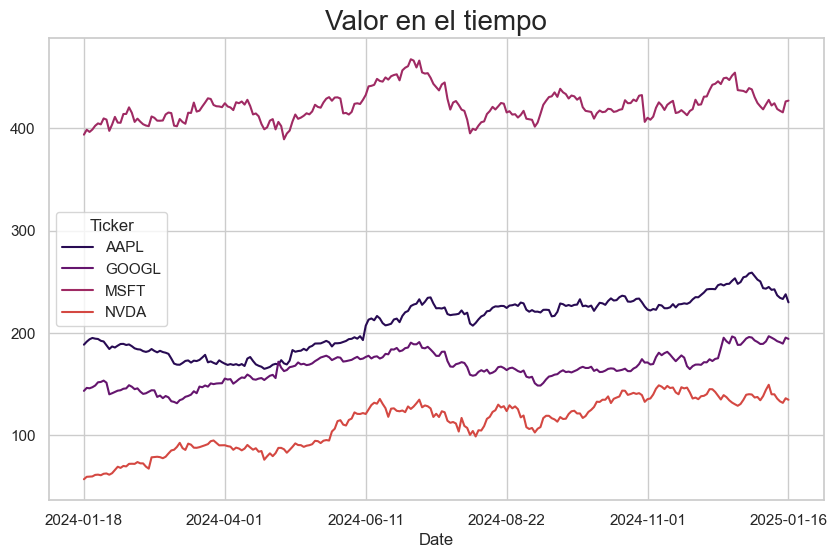

In [637]:
df.plot()
plt.title("Valor en el tiempo", fontsize = 20)
plt.gcf().set_size_inches(10, 6)
plt.show()

## **1. Retorno del Portafolio**

$$
\LARGE
 R_p = 

\begin{bmatrix}
w_1 & w_2 & \cdots & w_n
\end{bmatrix}
\begin{bmatrix}
r_{1,1} & r_{1,2} & \cdots & r_{1,T} \\
r_{2,1} & r_{2,2} & \cdots & r_{2,T} \\
\vdots & \vdots & \ddots & \vdots \\
r_{n,1} & r_{n,2} & \cdots & r_{n,T}
\end{bmatrix}
= \sum_{i=1}^n w_i \cdot r_i
$$

Retorno promedio diario: 0.14%
Retorno histórico: 36.033356%


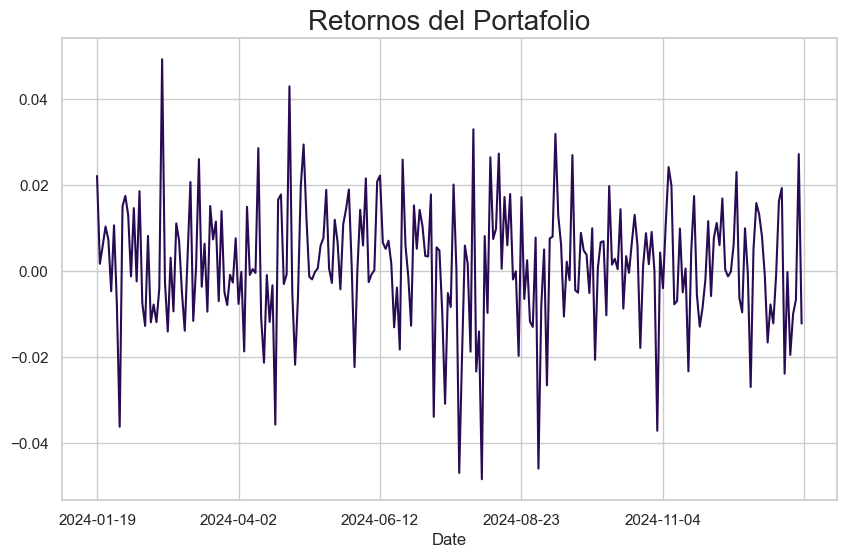

In [638]:
# Hallamos los retornos logarítmicos
log_returns = np.log(df/df.shift(1)).dropna()

# Establecemos un peso igual a los activos dentro del portafolio 
# (la suma debe ser la unidad)
weights = [1/len(df.columns)] * len(df.columns)

# Calculamos los retornos del portafolio
pf_log_returns = log_returns.dot(weights)

pf_mean_return = pf_log_returns.mean()
pf_historical_return = np.sum(pf_log_returns)

print(f"Retorno promedio diario: {pf_mean_return:.2%}")
print(f"Retorno histórico: {pf_historical_return:2%}")

# Gráficamos
pf_log_returns.plot()
plt.title("Retornos del Portafolio", fontsize = 20)
plt.gcf().set_size_inches(10,6)
plt.show()

### Su distribución:

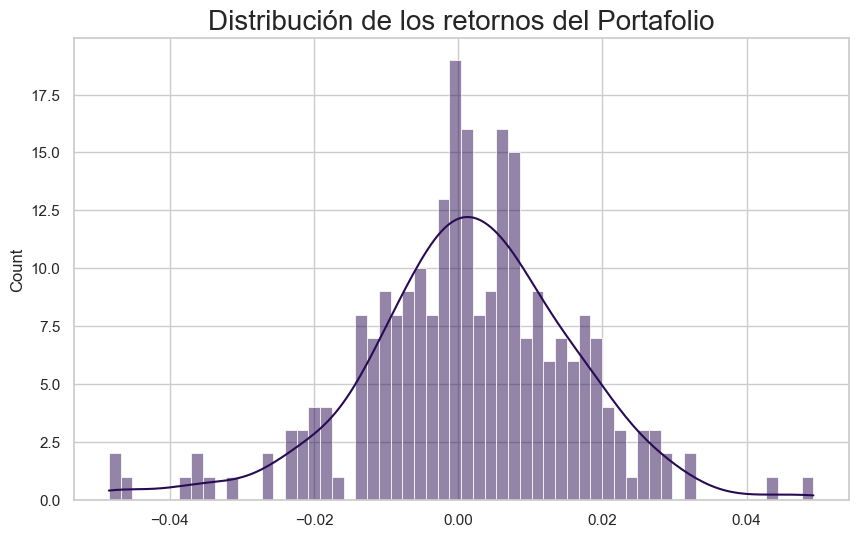

In [639]:
sns.histplot(data = pf_log_returns, 
             kde = True,
             bins = 60)
plt.title("Distribución de los retornos del Portafolio", fontsize = 20)
plt.xlabel("")
plt.gcf().set_size_inches(10, 6)
plt.show()

### Y para la evolución del valor de la inversión:

$$
FV_t = PV_0 \cdot (1 + r) \odot \cdots \odot 1
$$


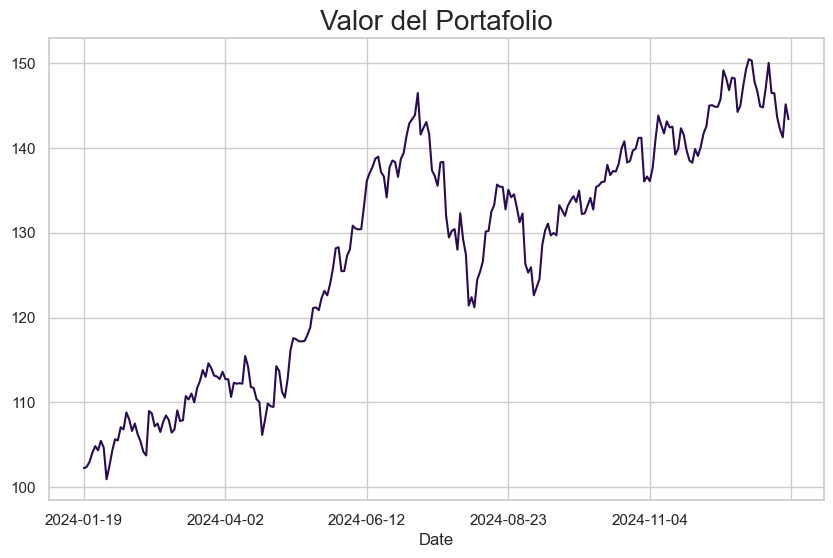

In [640]:
# Se invierte 100
investment = 100

# Hallamos el valor del portafolio a través del tiempo
pf_price = investment * (1 + (np.exp(pf_log_returns) - 1)).cumprod()

# Gráficamos
pf_price.plot()
plt.title("Valor del Portafolio", fontsize = 20)
plt.gcf().set_size_inches(10, 6)


## **2. Volatilidad del Portafolio**

$$ 
\LARGE
\sigma_p = \sqrt{
\begin{bmatrix}
w_1 & w_2 & \cdots & w_n
\end{bmatrix} 
\begin{bmatrix}
\sigma_{1}^2 & \sigma_{1,2} & \cdots & \sigma_{1,n} \\
\sigma_{2} & \sigma_{2,2}^2 & \cdots & \sigma_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n,1} & \sigma_{n,2} & \cdots & \sigma_{n,n}^2
\end{bmatrix}
\begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}
}
= \sqrt{w'\sum w}
$$

Volatilidad diaria: 1.46%
Volatilidad histórica: 23.22%


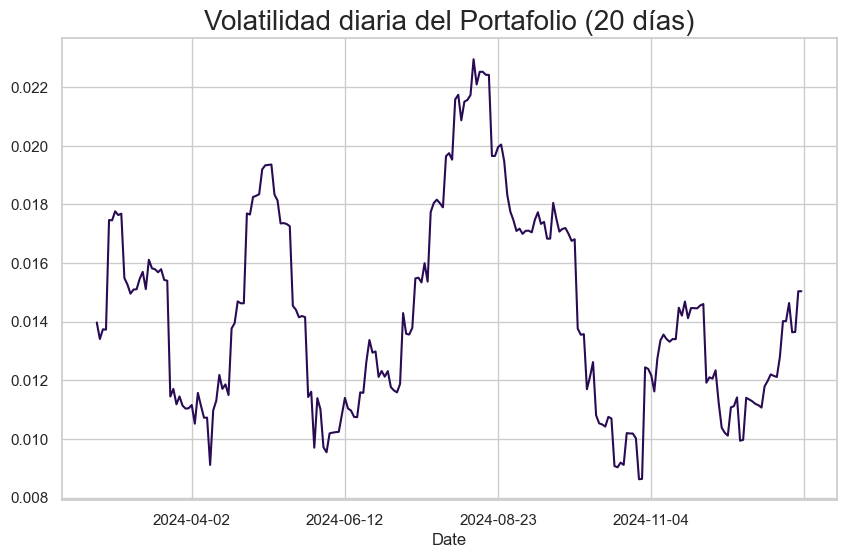

In [641]:
# Hallamos la volatilidad diaria con un ventana móvil de 20 días
vol_rolling = pf_log_returns.rolling(20).std()

# Volatilidad diaria e histórica
pf_vol = np.sqrt(weights @ log_returns.cov() @ weights)
#(tambien se pudo haber hecho con "np.pf_log_returns.std()")
pf_annual_vol = pf_vol * np.sqrt(252)

print(f"Volatilidad diaria: {pf_vol:.2%}")
print(f"Volatilidad histórica: {pf_annual_vol:.2%}")

# Gráficamos
vol_rolling.plot()
plt.title("Volatilidad diaria del Portafolio (20 días)", fontsize = 20)
plt.gcf().set_size_inches(10, 6)

## **2. VaR (Paramétrico)** 

$$ 
\LARGE
\text{VaR}_p = \alpha \cdot \sigma_p \cdot W
$$

### $W$: Valor del Portafolio.
### $\alpha$: El Z-score correspondiente a un nivel de confianza, e.g 99%.

### Y para cambiar la volatilidad anualizada a otros períodos:

$$
\LARGE
\sigma_{\text{Periodo}} = \sigma_{anual} \cdot \sqrt{\frac{\text{Periodo deseado}}{\text{Periodo anual}}}
$$

In [642]:
from scipy.stats import norm

def VaR(investment: float, annual_volatility: float, confidence: float,time_horizon: int = 252)-> float:

    z_score = norm.ppf(confidence)

    if time_horizon ==252:
        p_var = z_score * annual_volatility * investment
        return p_var
    else:
        adjusted_time_horizon = annual_volatility * np.sqrt(time_horizon / 252)
        p_var2 = z_score * adjusted_time_horizon * investment
        return p_var2


El VaR del Portafolio a un año es: 54.02
El VaR del Portafolio a 10 días es: 3.402940


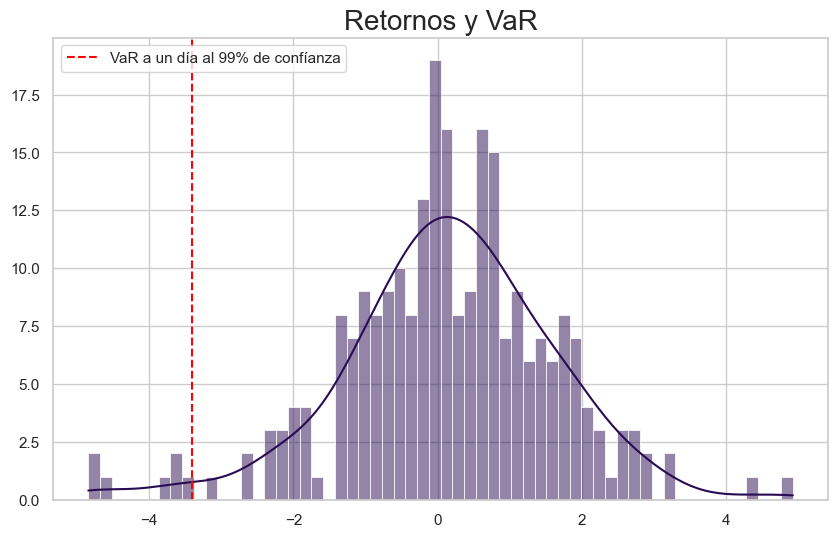

In [643]:
# A 10 días
pf_var_one_day = VaR(investment = 100,
                     confidence = .99,
                     annual_volatility= pf_annual_vol,
                     time_horizon = 1)

# Probamos la función a un año
pf_var_annual = VaR(investment = 100,
             confidence= .99,
             annual_volatility = pf_annual_vol)


print(f"El VaR del Portafolio a un año es: {pf_var_annual:.2f}")
print(f"El VaR del Portafolio a 10 días es: {pf_var_one_day:2f}")

# Gráficamos
sns.histplot(data = pf_log_returns * investment,
              bins= 60,
              kde = True)
plt.title("Retornos y VaR", fontsize= 20)
plt.axvline(-pf_var_one_day,
             color = "red",
             linestyle = "--", label = "VaR a un día al 99% de confíanza")
plt.legend(loc = 2)
plt.ylabel("")
plt.gcf().set_size_inches(10, 6)